In [1]:
# import sys,os
# sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_to_pybeh as pb
from pandas_to_pybeh import *
import seaborn as sns
import os,sys,argparse,glob
import cmlreaders as cml
from eeg_check import eeg_check,erp_sme

import json
from  matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

data_dir = "/scratch/EFRCourier_reports/"
os.chdir(data_dir)
CONFIG_FILE = '.config_ipynb'
if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
else:
    print("PUT IN SUBJECT SESSION INFO")

/home1/leochang/.local/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
# add 'phase' column to events df (with 'encoding', 'retrieval' for FR, FFR (final FR) or FSR (final store recall))
def add_phase(evs):
    new_evs = pd.DataFrame([])
    for ind,list_evs in evs.groupby('trial'): # 'trial' is the aquivalent of a delivery day
        
        if (list_evs['trial'].unique()!=-999) & (list_evs['trial'].unique()!=-1):
            list_evs['phase']='nan'

            # find indexes of encoding start and end
            first_pointing_index = min(list_evs[list_evs['type']=='pointing begins'].index)
            navigation_end_index = min(list_evs[list_evs['type']=='TRIAL_END'].index)-1
            list_evs.loc[first_pointing_index:navigation_end_index]['phase']='encoding'

            # find indexes of retrieval start and end
            rec_start_index = list_evs[list_evs['type']=='REC_START'].index[0]
            rec_end_index = list_evs[list_evs['type']=='REC_STOP'].index[0]
            list_evs.loc[rec_start_index:rec_end_index]['phase']='retrieval'

            if len(list_evs[list_evs.type=='FSR_START'])>0: # relevant only for the final trial
                # find indexes of Final FR for stores start and end
                FSR_start_index = list_evs[list_evs['type']=='FSR_START'].index[0]
                FSR_end_index = list_evs[list_evs['type']=='FSR_STOP'].index[0]
                list_evs.loc[FSR_start_index:FSR_end_index]['phase']='FSR'

                 # find indexes of Final FR for items start and end
                FFR_start_index = list_evs[list_evs['type']=='FFR_START'].index[0]
                FFR_end_index = list_evs[list_evs['type']=='FFR_STOP'].index[0]
                list_evs.loc[FFR_start_index:FFR_end_index]['phase']='FFR'

        elif list_evs['trial'].unique()==-999:
            list_evs['phase']='nan'
            

        new_evs=pd.concat([new_evs,list_evs])

    return new_evs



In [35]:
def add_cued_recalled(events):
    def find_recall(row):
        itemno = row['itemno']
        recalls = events[(events["type"] == 'CUED_REC_WORD') &
                         (events["session"] == row["session"]) &
                         (events["trial"] == row["trial"])]["itemno"].values
        return 1 if itemno in recalls else 0

    events = events.sort_values("mstime")
    events.loc[events["type"] =="WORD", "cuedrecalled"] = events.loc[events["type"] == "WORD"].apply(find_recall, axis=1)
    return events

def add_final_recalled(events):
    def find_recall(row):
        itemno = row['itemno']
        recalls = events[(events["type"] == 'FFR_REC_WORD') &
                         (events["session"] == row["session"])]["itemno"].values
        return 1 if itemno in recalls else 0

    events = events.sort_values("mstime")
    events.loc[events["type"] =="WORD", "finalrecalled"] = events.loc[events["type"] == "WORD"].apply(find_recall, axis=1)
    return events

In [3]:
whole_df = cml.CMLReader.get_data_index() 
sub_df_exp = 'EFRCourierReadOnly'
sub_df_subject = 'R1642J'# 'R1620J' # R1637T
sub_df_session=0
sub_df = whole_df.query('experiment == @sub_df_exp and subject == @sub_df_subject and session == @sub_df_session')

# sub_df_subject = sub_df.iloc[0]['subject']
# sub_df_exp = sub_df.iloc[0]['experiment']
# sub_df_session = sub_df.iloc[0]['session']
# sub_df

In [4]:
print(sub_df_subject+' subject, ' +sub_df_exp+ ' session '+str(sub_df_session))

R1642J subject, EFRCourierReadOnly session 0


In [41]:
reader = cml.CMLReader(subject=sub_df_subject, experiment=sub_df_exp, session=sub_df_session)
evs = reader.load('task_events')
evs.head(6)
full_evs = add_phase(evs)

def get_item_id(item, wordpool=[]):
    if item not in wordpool:
        return -999
    return wordpool.index(item) + 1

with open('/scratch/nicls_cns/dbpool.txt', "r") as f:
    wordpool = [w.strip().upper() for w in f.readlines()]    
    
full_evs['itemno'] = full_evs['item'].transform(get_item_id, wordpool=wordpool)
full_evs = add_cued_recalled(full_evs)
full_evs = add_final_recalled(full_evs)

In [6]:
word_evs = full_evs.query('type == "WORD"')
deliv_table = word_evs.groupby(["subject", "session"]).agg({"trial":pd.Series.nunique}).reset_index()
deliv_table

,subject,session,trial
0,R1642J,0,3


# Navigation Logistics

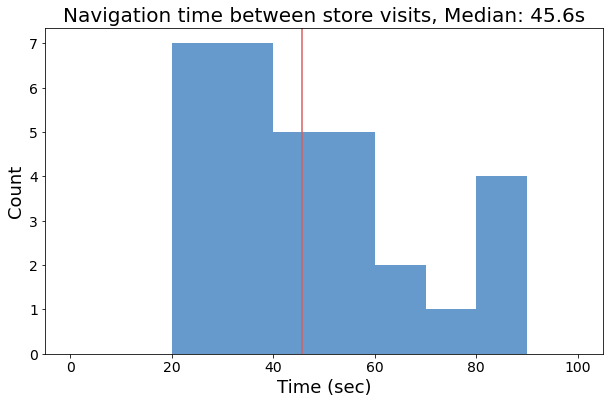

In [72]:
word_evs = full_evs.query('type == "WORD"')
total_delivery_time = []

for trial, trial_evs in word_evs.groupby("trial"):
    delivery_times = np.diff(trial_evs.mstime) / 1000
    total_delivery_time.extend(delivery_times)

median = np.round(np.median(total_delivery_time),1)
    
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(total_delivery_time, color=(0.4,0.6,0.8), range=(0, 100))
plt.axvline(np.median(total_delivery_time), color="r")
plt.title("Navigation time between store visits, Median: {}s".format(median), fontsize=20)
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Recall Rates

In [54]:
word_evs = full_evs.query('type == "WORD"')
total_word_count = len(word_evs)
total_recall_count = np.sum(word_evs.recalled)
total_cued_recall_count = np.sum(word_evs.cuedrecalled)
total_final_recall_count = np.sum(word_evs.finalrecalled)

data = {"Type":["Immediate", "Cued", "Final"], "Recall":[total_recall_count, total_cued_recall_count, total_final_recall_count], "Total":[total_word_count, total_word_count, total_word_count]}
recall_df = pd.DataFrame(data=data)

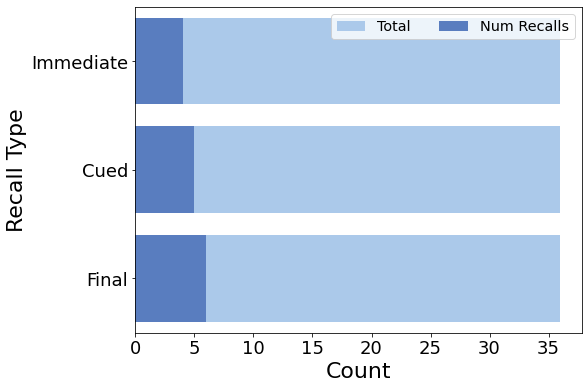

In [59]:
fig = plt.figure(figsize=(8,6))

sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Type", data=recall_df, label="Total", color="b", orient="h")

sns.set_color_codes("muted")
sns.barplot(x="Recall", y="Type", data=recall_df, label="Num Recalls", color="b", orient="h")

plt.tick_params(labelsize=18)
plt.xlabel("Count", fontsize=22)
plt.ylabel("Recall Type", fontsize=22)

plt.legend(ncol=2, loc="upper right", frameon=True, fontsize="x-large")

plt.show()

# Intrusion Analysis

In [76]:
rec_evs

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,montage,msoffset,mstime,phase,presX,presZ,protocol,recalled,rectime,serialpos,session,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,cuedrecalled
126,2573900,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,TULIP,-999,0,20,1669062499202,retrieval,-999,-999,r1,-999,28373,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
127,2578801,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,CAT,258,0,20,1669062504103,retrieval,-999,-999,r1,-999,33274,3,0,pet_store,-3.070312,-58.50000,R1642J,-999.0,0,REC_WORD,NaN
128,2583979,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,TULIP,-999,0,20,1669062509281,retrieval,-999,-999,r1,-999,38452,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
129,2584745,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,CAT,258,0,20,1669062510047,retrieval,-999,-999,r1,-999,39218,3,0,pet_store,-3.070312,-58.50000,R1642J,-999.0,0,REC_WORD,NaN
130,2589993,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,CLIPPERS,-999,0,20,1669062515295,retrieval,-999,-999,r1,-999,44466,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
131,2594937,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BRUSHES,17,0,20,1669062520239,retrieval,-999,-999,r1,-999,49410,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
133,2600019,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,DENTIST,-999,0,20,1669062525321,retrieval,-999,-999,r1,-999,54492,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
135,2605577,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BRACES,-999,0,20,1669062530879,retrieval,-999,-999,r1,-999,60050,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
140,2620132,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,EARRINGS,157,0,20,1669062545434,retrieval,-999,-999,r1,-999,74605,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN
142,2626961,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BAKERY,-999,0,20,1669062552263,retrieval,-999,-999,r1,-999,81434,-999,0,-999,-999.000000,-999.00000,R1642J,-999.0,0,REC_WORD,NaN


In [77]:
full_evs.query('type == "EFR_MARK"')

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,montage,msoffset,mstime,phase,presX,presZ,protocol,recalled,rectime,serialpos,session,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,cuedrecalled
419,4758199,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,0,EFRCourierReadOnly,-999,-999,-999,-999,-999,0,-1,1669064683501,FSR,-999,-999,r1,-999,-999,-999,0,-999,-999.0,-999.0,R1642J,-999.0,2,EFR_MARK,NaN
418,4758199,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,0,EFRCourierReadOnly,-999,-999,-999,-999,-999,0,-1,1669064683501,FSR,-999,-999,r1,-999,-999,-999,0,-999,-999.0,-999.0,R1642J,-999.0,2,EFR_MARK,NaN
422,4767884,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,0,EFRCourierReadOnly,-999,-999,-999,-999,-999,0,-1,1669064693186,FSR,-999,-999,r1,-999,-999,-999,0,-999,-999.0,-999.0,R1642J,-999.0,2,EFR_MARK,NaN
421,4767884,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,0,EFRCourierReadOnly,-999,-999,-999,-999,-999,0,-1,1669064693186,FSR,-999,-999,r1,-999,-999,-999,0,-999,-999.0,-999.0,R1642J,-999.0,2,EFR_MARK,NaN


In [78]:
full_evs.type.unique()

array(['START', 'store mappings', 'TL_START', 'pointing begins',
       'pointing finished', 'POINTER_ON', 'TL_END',
       'PRACTICE_DELIVERY_START', 'PRACTICE_WORD',
       'PRACTICE_DELIVERY_END', 'REC_START', 'REC_STOP', 'CUED_REC_CUE',
       'CUED_REC_STOP', 'TRIAL_START', 'WORD', 'TRIAL_END', 'REC_WORD_VV',
       'REC_WORD', 'CUED_REC_WORD', 'CUED_REC_WORD_VV', 'FSR_START',
       'SR_REC_WORD_VV', 'SR_REC_WORD', 'EFR_MARK', 'FSR_STOP',
       'FFR_START', 'FFR_REC_WORD', 'FFR_REC_WORD_VV', 'FFR_STOP',
       'SESS_END'], dtype=object)

In [110]:
recall_periods = ["REC_WORD", "CUED_REC_WORD", "SR_REC_WORD", "FFR_REC_WORD"]
# recall_periods = ["SR_REC_WORD"]

for recall_period in recall_periods:
    curr_evs = full_evs.query('type == @recall_period').reset_index()
    
    for i, row in curr_evs.iterrows():
        if i == len(curr_evs)-1:
            continue
        
        curr_time = row.mstime
        next_time = curr_evs.iloc[i+1].mstime
        
        # locate any EFR events in between
        candidate_evs = full_evs.query('type == "EFR_MARK"')
        candidate_evs = candidate_evs.query('@curr_time < mstime < @next_time')
        if len(candidate_evs) > 0:
            display(candidate_evs)
        

In [114]:
full_evs.query('type == ["SR_REC_WORD","EFR_MARK"]')

,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,montage,msoffset,mstime,phase,presX,presZ,protocol,recalled,rectime,serialpos,session,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,cuedrecalled
395,4685525,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,GROCERY STORE,-999,0,20,1669064610827,nan,-999,-999,r1,-999,6660,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
396,4688357,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,JEWELRY STORE,-999,0,20,1669064613659,nan,-999,-999,r1,-999,9492,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
397,4691235,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BIKE SHOP,-999,0,20,1669064616537,nan,-999,-999,r1,-999,12370,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
399,4694409,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,JEWELRY STORE,-999,0,20,1669064619711,nan,-999,-999,r1,-999,15544,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
400,4697254,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,CAFE,-999,0,20,1669064622556,nan,-999,-999,r1,-999,18389,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
401,4700530,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,PHARMACY,-999,0,20,1669064625832,nan,-999,-999,r1,-999,21665,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
402,4710315,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BIKE SHOP,-999,0,20,1669064635617,nan,-999,-999,r1,-999,31450,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
403,4714018,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,FLORIST,-999,0,20,1669064639320,nan,-999,-999,r1,-999,35153,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
406,4728883,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,BAKERY,-999,0,20,1669064654185,nan,-999,-999,r1,-999,50018,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
409,4734932,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,CLOTHING STORE,-999,0,20,1669064660234,nan,-999,-999,r1,-999,56067,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN


In [98]:
curr_evs

,index,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,montage,msoffset,mstime,phase,presX,presZ,protocol,recalled,rectime,serialpos,session,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,cuedrecalled
0,395,4685525,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,GROCERY STORE,-999,0,20,1669064610827,nan,-999,-999,r1,-999,6660,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
1,396,4688357,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,JEWELRY STORE,-999,0,20,1669064613659,nan,-999,-999,r1,-999,9492,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
2,397,4691235,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BIKE SHOP,-999,0,20,1669064616537,nan,-999,-999,r1,-999,12370,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
3,399,4694409,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,JEWELRY STORE,-999,0,20,1669064619711,nan,-999,-999,r1,-999,15544,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
4,400,4697254,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,CAFE,-999,0,20,1669064622556,nan,-999,-999,r1,-999,18389,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
5,401,4700530,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,PHARMACY,-999,0,20,1669064625832,nan,-999,-999,r1,-999,21665,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
6,402,4710315,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,BIKE SHOP,-999,0,20,1669064635617,nan,-999,-999,r1,-999,31450,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
7,403,4714018,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,FLORIST,-999,0,20,1669064639320,nan,-999,-999,r1,-999,35153,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
8,406,4728883,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,0,BAKERY,-999,0,20,1669064654185,nan,-999,-999,r1,-999,50018,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN
9,409,4734932,-999.0,R1642J_EFRCourierReadOnly_0_21Nov22_1145,-999,EFRCourierReadOnly,-999,-999,-1,CLOTHING STORE,-999,0,20,1669064660234,nan,-999,-999,r1,-999,56067,-999,0,-999,-999.0,-999.0,R1642J,-999.0,-999,SR_REC_WORD,NaN


In [100]:
next_index

1

In [101]:
curr_evs.query('index == @next_index')

,index,eegoffset,correctPointingDirection,eegfile,efr_mark,experiment,finalrecalled,intruded,intrusion,item,itemno,montage,msoffset,mstime,phase,presX,presZ,protocol,recalled,rectime,serialpos,session,store,storeX,storeZ,subject,submittedPointingDirection,trial,type,cuedrecalled


In [73]:
#FREE RECALL
# Correct Rejection : intrusion != 0 and keypress == True
# False Alarm: intrusion == 0 / recalled == 1 and keypress == True
# Miss : intrusion != 0 and keypress == False
# Hit: intrusion == 0 and keypress == False

#CUED RECALL                              #intra-list intrusion
# Correct Rejection : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == True
# False Alarm: recalled == 1 and keypress == True
# Miss : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == False
# Hit: intrusion == 0 and recalled == 1 and keypress == False

intrusion_df = pd.DataFrame(columns=["subject", "session", "trial", "type", "intrusion_type"])

rec_evs = full_evs.query('type == "REC_WORD"')
for i, row in rec_evs.iterrows():
    if row.intrusion != 0 and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif (row.intrusion == 0 or row.recalled == 1) and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion != 0 and row.efr_mark != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion == 0 and row.efr_mark != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
cued_rec_evs = full_evs.query('type == "CUED_REC_WORD"')
for i, row in cued_rec_evs.iterrows():
    if ( row.intrusion != 0 or (row.intrusion == 0 and row.recalled == 0) ) and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif ( row.intrusion != 0 or (row.intrusion == 0 and row.recalled == 0) ) and row.efr_mark != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion == 0 and row.recalled == 1 and row.efr_mark != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Cued Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
ffr_rec_evs = full_evs.query('type == "FFR_REC_WORD"')
for i, row in ffr_rec_evs.iterrows():
    if row.intrusion < 0 and row.efr_mark == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.efr_mark == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion < 0 and row.efr_mark != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion >= 0 and row.efr_mark != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Final Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)

In [74]:
table = intrusion_df.groupby(["subject", "session", "trial", "type", "intrusion_type"]).size().reset_index(name='counts')

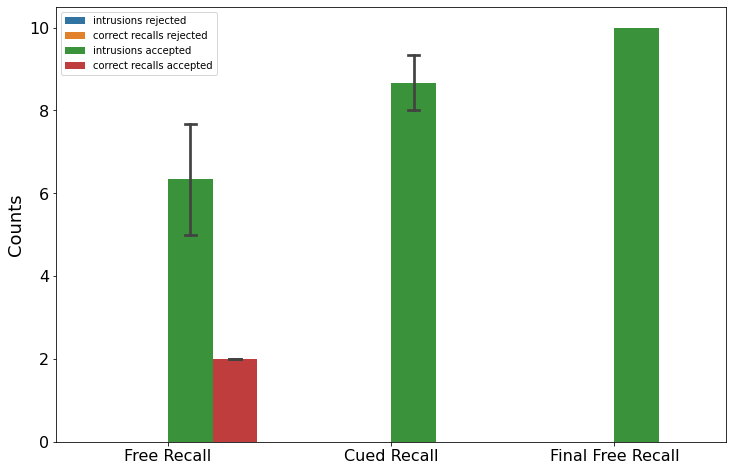

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.barplot(data=table, 
                x="type", 
                order=["Free Recall", "Cued Recall", "Final Free Recall"],
                y="counts", 
                hue="intrusion_type", 
                hue_order=["intrusions rejected", 
                           "correct recalls rejected", 
                           "intrusions accepted", 
                           "correct recalls accepted"],
#                 palette="crest",
                ci=68,
                capsize=0.05)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Counts", fontsize=18)
plt.gca().legend().set_title('')
# ax.yaxis.grid()
plt.show()

** Note that this is the sum over all delivery days

- Intrusions rejected: Intrusions that were correctly rejected
- Correct recalls rejected: Correct recalls that were incorrectly rejected
- Intrusions accepted: Correct recalls that were not rejected
- Correct recalls accepted: Intrusions that were not rejected

# SPC

In [ ]:
spc_df = full_evs.query("type=='WORD'").groupby(['subject', 'session', 'serialpos']) \
                                       .agg({'recalled':np.nanmean}).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))
spc = sns.pointplot(data=spc_df, x='serialpos', y='recalled', ci=68,
                    color='k', err_style='bars', capsize=.3, label="SPC")

plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Serial Position Curve", fontsize=20)
plt.show()

In [ ]:
recword = full_evs.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']

fig, ax = plt.subplots(figsize=(12, 8))
pfr = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=68,
                    color='k', err_style='bars', capsize=.1)
plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Probability of First Recall", fontsize=20)
plt.show()

# Lag CRP

In [ ]:
full_evs['itemno'] = full_evs['item'].astype('category').cat.codes
crp_df = full_evs.groupby(['subject']).apply(
    pb.pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=5).reset_index()

fig, ax = plt.subplots(figsize=(12,8))
crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=68,
                    color='k', err_style='bars', capsize=.2)
plt.title("Lag CRP", fontsize=20)
plt.xlabel("Lag", fontsize=18)
plt.ylabel("Conditional Recall Probability (%)", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.grid()
# p.yaxis.grid()
plt.show()

# Spatial CRP

In [ ]:
# def isolate_storeX(row):
#     store_location = eval(row['store position'])
#     return store_location[0]

# def isolate_storeZ(row):
#     store_location = eval(row['store position'])
#     return store_location[2]

# def isolate_playerX(row):
#     player_position = eval(row['player position'])
#     return player_position[0]

# def isolate_playerZ(row):
#     player_position = eval(row['player position'])
#     return player_position[2]

# full_evs.loc[full_evs["type"] == "WORD", "storeX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeX, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "storeZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeZ, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "presX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerX, axis=1)
# full_evs.loc[full_evs["type"] == "WORD", "presZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerZ, axis=1)

In [ ]:
def get_new_item_id(item, wordpool=[]):
    if item not in wordpool:
        return -999
    return wordpool.index(item)

# need to redo itemno because not using all items in wordpool
word_evs = full_evs.query('type == "WORD" and itemno > -1')
wordpool_subset = word_evs.item.unique().tolist()
full_evs['itemno'] = full_evs['item'].transform(get_new_item_id, wordpool=wordpool_subset)

In [ ]:
word_evs = full_evs.query('itemno != -999 and type == "WORD"')
store_items = word_evs[['store', 'item', 'itemno']].drop_duplicates()
sub_store_locs = word_evs[['store', "storeX", "storeZ", 'subject']].drop_duplicates()
sub_store_locs['type'] = 'WORD_VALS'
loc_evs = sub_store_locs.merge(store_items)
loc_evs = loc_evs.sort_values('itemno')
test_evs = full_evs.append(loc_evs)

In [ ]:
bins = [12.96160383, 41.99123618, 61.53639199, 77.73374529, 97.11224258]

spatial_crp = test_evs.groupby(['subject']).apply(
    pb.pd_sem_crp, list_index=['subject', 'session', 'trial'], 
    sim_columns=['storeX', 'storeZ'], bins=bins, ret_counts=False).reset_index()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.patch.set_facecolor('white')
ax1 = sns.pointplot(data=spatial_crp, x='sem_bin', y='prob', marker = 'o', color = 'black', capsize=0.1, ci=68)
ax1.set_xlabel('Distance bin', fontsize=18)
ax1.set_xticklabels(["very near", "near", "intermediate", "far", "very far"], fontsize=14)
ax1.set_ylabel('Conditional response probability (%)', fontsize=18)
plt.yticks(fontsize=14)
ax1.yaxis.grid()
plt.tick_params(labelsize=16)
plt.ylim(0)
plt.title("Spatial CRP", fontsize=20)
plt.show()

# Pointing Task

In [ ]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.pi/18

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=True, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [ ]:
pointing_evs = full_evs[full_evs.type == 'pointing finished']
# filt_point_evs = pointing_evs[(pointing_evs['presX']) != -999.00]
# print(len(pointing_evs))
# print(len(filt_point_evs))
#find the raw pointing error for each pointing task completed
submitted_point = pointing_evs['submittedPointingDirection'] 
correct_point = pointing_evs['correctPointingDirection']
difference = np.radians(submitted_point - correct_point)
difference = (difference + np.pi) % (2 * np.pi) - np.pi
difference = np.array(difference)

#find the store locations for all stores visited 
store_evs = full_evs[~pd.isnull(full_evs['storeX'])]
store_evs = store_evs[~pd.isnull(store_evs['store'])]
stores = store_evs.groupby('store')
stores = stores.agg('mean')[['storeX', 'storeZ']]
storeX = stores['storeX'].values
storeZ = stores['storeZ'].values

pos_angles = []
correct_point = np.array(correct_point)
x = 0
for i, finished_row in pointing_evs.iterrows():
    position_x, position_z = finished_row[['presX', 'presZ']]
    difference_x = (storeX - position_x)
    difference_z = (storeZ - position_z)
    angle = np.arctan2(difference_z, difference_x) 
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    angle = np.abs(angle)
    pos_angles.append(np.median(angle - correct_point[x]))
    x = x + 1

# apply correction of pointing error and wrap again to display nicely
pos_angles = np.array(pos_angles)
pos_angles = np.radians(pos_angles)
point_error = difference/ pos_angles
point_error = (point_error + np.pi) % (2 * np.pi) - np.pi


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection = 'polar')

n, bins, _ = circular_hist(ax, point_error, offset = np.pi/2, bins = 30, density = False)
plt.title('Pointing Error ($\sigma = {:.2f}$)'.format(point_error.std()*180/np.pi))
ax.vlines([np.mean(point_error)+point_error.std(), np.mean(point_error)-point_error.std()], ymin = 0, 
          ymax = np.max(point_error.size/np.pi)*0.35, ls = "--", colors = 'k')
ax.vlines(np.mean(point_error), ymin = 0, ymax=np.max(point_error.size/np.pi)*0.35,ls = '--', colors = 'r')
plt.show()


# Navigation Trajectory

In [ ]:
# import random
# import os
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection

# if len(deliv_table) > 3:
#     print("Too many subjects and sessions")
# else:
#     for i, row in deliv_table.iterrows():

#         print("{} session {}".format(row.subject, row.session))
#         # pull up jsonl file from data2 directory
#         file_name = "{}/behavioral/EFRCourierReadOnly/session_{}/session.jsonl".format(row.subject, row.session)
#         file_dir = os.path.join("/data10/RAM/subjects/", file_name)

#         new_file = []
#         for line in open(file_dir, "r"):
#             # replace this specific entry to empty string
#             if '"point condition":SerialPosition,' in line:
#                 line = line.replace('"point condition":SerialPosition,', '')
#             elif '"point condition":SpatialPosition,' in line:
#                 line = line.replace('"point condition":SpatialPosition,', '')
#             elif '"point condition":Random,' in line:
#                 line = line.replace('"point condition":Random,', '')

#             data_dict = json.loads(line)
#             new_file.append(data_dict)

#         with open("session_tmp.jsonl", "w") as outfile:
#             for line in new_file:
#                 json.dump(line, outfile)
#                 outfile.write('\n')

#         log = pd.read_json("session_tmp.jsonl", lines=True)
#         log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

#         def extract_position(row):
#             if row.type=='PlayerTransform':
#                 return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
#             elif row.type=='object presentation begins':
#                 return eval(row['data']['player position'])
#             else:
#                 return np.nan

#         log['location']=log.apply(extract_position, axis=1)
#         log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
#         movements = log.fillna(method='pad').dropna()
#         sess_pos = np.stack(list(map(list, movements.location.values)))

#         group_mov = movements.groupby('trial')    
#         dd_list = np.array(list(group_mov.groups.keys())).astype(int)
#         pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]

#         fig, ax = plt.subplots(len(dd_list)//2 + len(dd_list)%2, 2, 
#                                figsize= (20, 8*(len(dd_list)//2 + len(dd_list)%2)) )
#         ax = ax.ravel()


#         for i, dd in enumerate(dd_list):
#             store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
#             store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
#             list_stores = np.stack(list(map(list, store_locs.values)))


#             points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
#             segments = np.concatenate([points[:-1], points[1:]], axis=1)

#             # don't count motionless time
#             segments = segments[1:][np.any(np.diff(segments, axis=0)!=0, axis=(1, 2))]
#             lc = LineCollection(segments, cmap='copper_r')
#             # Set the values used for colormapping
#             lc.set_array(np.linspace(0, 1, len(segments)))
#             lc.set_linewidth(3); lc.set_alpha(.6)
#             line = ax[i].add_collection(lc)
#             ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
#             texts = []
#             for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
#                 texts.append(ax[i].text(x-10, y+5, name.capitalize() + ' ({})'.format(order)))
#             ax[i].set_title('Delivery Day %d' %(dd+1), fontsize=20)
#             ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
#         #         adjust_text(texts, expand_text=(1.2, 1.2))


#             positions = []
#             tmp_texts = []
#             for text in texts:
#         #             print(text.get_position())
#                 positions.append(text.get_position())
#                 tmp_texts.append(text)

#             point1_1 = (26.700000000000003, 64.1)
#             if point1_1 in positions:
#                 text1 = tmp_texts[positions.index(point1_1)]
#                 text1.set_visible(False)
#                 ax[i].text(26.7, 54.1, text1.get_text())

#             if ((25.1, 31.7) in positions) and ((48.3, 32.9) in positions):
#                 text1 = tmp_texts[positions.index((25.1, 31.7))]
#                 text2 = tmp_texts[positions.index((48.3, 32.9))]

#                 text1.set_visible(False); text2.set_visible(False)

#                 ax[i].text(15.1, 31.7, text1.get_text())
#                 ax[i].text(52.3, 32.9, text2.get_text())

#             point3_1 = (4.5, -28.700000000000003); point3_2 = (25.4, -28.1); point3_3 = (52.3, -28.5)
#             if (point3_1 in positions) and (point3_2 in positions):

#                 if point3_3 in positions:
#                     text1 = tmp_texts[positions.index(point3_1)]
#                     text2 = tmp_texts[positions.index(point3_2)]
#                     text3 = tmp_texts[positions.index(point3_3)]

#                     text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

#                     ax[i].text(-10, -28.700000000000003, text1.get_text())
#                     ax[i].text(20.4, -28.1, text2.get_text())
#                     ax[i].text(61.3, -28.5, text3.get_text())
#                 else:
#                     text1 = tmp_texts[positions.index(point3_1)]
#                     text2 = tmp_texts[positions.index(point3_2)]

#                     text1.set_visible(False); text2.set_visible(False)

#                     ax[i].text(-7, -28.700000000000003, text1.get_text())
#                     ax[i].text(25.4, -28.1, text2.get_text())

#             elif (point3_2 in positions) and (point3_3 in positions):
#                 text1 = tmp_texts[positions.index(point3_2)]

#                 text1.set_visible(False)

#                 ax[i].text(10.4, -28.1, text1.get_text())

#             point4_1 = (-13.1, -53.5); point4_2 = (4.6, -53.8); point4_3 = (22.200000000000003, -55.9)
#             if (point4_1 in positions) and (point4_2 in positions):

#                 if point4_3 in positions:
#                     text1 = tmp_texts[positions.index(point4_1)]
#                     text2 = tmp_texts[positions.index(point4_2)]
#                     text3 = tmp_texts[positions.index(point4_3)]

#                     text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

#                     ax[i].text(-20, -65.5, text1.get_text())
#                     ax[i].text(0, -53.8, text2.get_text())
#                     ax[i].text(30, -55.9, text3.get_text())
#                 else:
#                     text1 = tmp_texts[positions.index(point4_1)]
#                     text2 = tmp_texts[positions.index(point4_2)]

#                     text1.set_visible(False); text2.set_visible(False)

#                     ax[i].text(-20, -53.5, text1.get_text())
#                     ax[i].text(5, -53.8, text2.get_text())

#             elif (point4_2 in positions) and (point4_3 in positions):
#                 text1 = tmp_texts[positions.index(point3_2)]

#                 text1.set_visible(False)

#                 ax[i].text(0, -53.8, text1.get_text())


#         fig.subplots_adjust(hspace=0.2, wspace=0.2)
#         plt.tight_layout()
#         cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.7)
#         cbar.ax.tick_params(labelsize=16)
#         cbar.ax.set_yticklabels(["Start", "", "", "", "", "End"])
#         fig.set_facecolor('white')
#         for a in ax:
#             a.axis("off")
#         plt.show()